# Práctica Calificada 2
---
**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi


import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
%matplotlib inline

* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

<h4>Poblacion</h4>

In [15]:
%%time
df = pd.read_csv("100k_train.csv") # cambiar esto por train.csv para cargar los 55M .

CPU times: user 164 ms, sys: 20 ms, total: 184 ms
Wall time: 197 ms


In [16]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+05,100000.000000,100000.000000,100000.000000,99999.000000,99999.000000,100000.000000
mean,2.771124e+07,11.336822,-72.471349,39.895982,-72.495088,39.905861,1.683360
std,1.601008e+07,9.707742,10.587718,6.423522,10.735315,6.394699,1.306758
min,2.030000e+02,-8.500000,-83.353842,-74.017740,-736.500000,-74.015572,0.000000
25%,1.384279e+07,6.000000,-73.992120,40.734982,-73.991362,40.734040,1.000000
50%,2.773127e+07,8.500000,-73.981845,40.752628,-73.980120,40.753255,1.000000
75%,4.157677e+07,12.500000,-73.967078,40.767047,-73.963554,40.768178,2.000000
max,5.542340e+07,238.000000,40.800855,404.666667,40.869710,404.383332,8.000000


<h4>Muestra</h4>

In [17]:
%%time
# 1000000 sample
df_s = df.sample(100000, random_state = 7)

CPU times: user 20.4 ms, sys: 53 µs, total: 20.4 ms
Wall time: 24 ms


In [18]:
df_s.head(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
33909,6995983,2010-04-09 21:07:00.00000031,12.9,2010-04-09 21:07:00 UTC,-73.982005,40.755532,-73.986393,40.722167,1
92307,50914033,2010-04-27 13:01:26.0000005,8.9,2010-04-27 13:01:26 UTC,-73.992916,40.747968,-73.990090,40.771926,1
89107,1385641,2013-04-12 01:00:00.000000149,15.0,2013-04-12 01:00:00 UTC,-73.993250,40.738415,-73.948227,40.773012,1
9538,32496265,2011-12-12 20:17:00.000000268,7.3,2011-12-12 20:17:00 UTC,-73.987408,40.719842,-74.009960,40.728983,1
31008,28151968,2009-12-25 00:37:33.0000001,15.7,2009-12-25 00:37:33 UTC,-73.925891,40.761700,-73.999438,40.730170,3


In [19]:
df_s.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+05,100000.000000,100000.000000,100000.000000,99999.000000,99999.000000,100000.000000
mean,2.771124e+07,11.336822,-72.471349,39.895982,-72.495088,39.905861,1.683360
std,1.601008e+07,9.707742,10.587718,6.423522,10.735315,6.394699,1.306758
min,2.030000e+02,-8.500000,-83.353842,-74.017740,-736.500000,-74.015572,0.000000
25%,1.384279e+07,6.000000,-73.992120,40.734982,-73.991362,40.734040,1.000000
50%,2.773127e+07,8.500000,-73.981845,40.752628,-73.980120,40.753255,1.000000
75%,4.157677e+07,12.500000,-73.967078,40.767047,-73.963554,40.768178,2.000000
max,5.542340e+07,238.000000,40.800855,404.666667,40.869710,404.383332,8.000000


In [6]:
df_s.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

<h4>Data Cleaning y Transformación de la Data</h4>

In [53]:
# Se trabajará con la siguiente data
data = df_s[(-180.0 <= df_s["pickup_longitude"]) & (df_s["pickup_longitude"] <= 180.0) &
            (-90.0 <= df_s["pickup_latitude"]) & (df_s["pickup_latitude"] <= 90.0) & 
            (-180.0 <= df_s["dropoff_longitude"]) & (df_s["dropoff_longitude"] <= 180.0) &
            (-90.0 <= df_s["dropoff_latitude"]) & (df_s["dropoff_latitude"] <= 90.0)&
            (2.0 <= df_s["fare_amount"]) & (df_s["fare_amount"] <= 200) & 
            (0.0<=df_s["passenger_count"]) & (df_s["passenger_count"]<= 8)]

data ['pickup_datetime'] = pd.to_datetime(data.pickup_datetime) # convertimos a tipo de dato de datetime
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour

data.drop(columns='key', inplace=True)
data.drop(columns='pickup_datetime', inplace=True)

data.head(5)


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
33909,6995983,12.9,-73.982005,40.755532,-73.986393,40.722167,1,2010,4,9,21
92307,50914033,8.9,-73.992916,40.747968,-73.990090,40.771926,1,2010,4,27,13
89107,1385641,15.0,-73.993250,40.738415,-73.948227,40.773012,1,2013,4,12,1
9538,32496265,7.3,-73.987408,40.719842,-74.009960,40.728983,1,2011,12,12,20
31008,28151968,15.7,-73.925891,40.761700,-73.999438,40.730170,3,2009,12,25,0


In [38]:
data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
count,9.998900e+04,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000
mean,2.771122e+07,11.333317,-72.472663,39.893063,-72.489794,39.902955,1.683395,2011.737731,6.267379,15.732381,13.491394
std,1.601022e+07,9.659590,10.583328,6.316924,10.523481,6.287746,1.306762,1.859483,3.438122,8.702115,6.536112
min,2.030000e+02,2.500000,-83.353842,-74.017740,-83.363788,-74.015572,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,1.384271e+07,6.000000,-73.992120,40.734982,-73.991362,40.734042,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,2.772974e+07,8.500000,-73.981846,40.752628,-73.980120,40.753253,1.000000,2012.000000,6.000000,16.000000,14.000000
75%,4.157728e+07,12.500000,-73.967080,40.767047,-73.963559,40.768177,2.000000,2013.000000,9.000000,23.000000,19.000000
max,5.542340e+07,180.000000,40.800855,45.883332,40.869710,42.430088,8.000000,2015.000000,12.000000,31.000000,23.000000


In [40]:
data.shape

(99989, 11)

In [46]:
data.sort_values(by='pickup_longitude', ascending=False).tail(5)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
67870,48933125,4.5,-75.396891,40.721390,-75.400610,40.710627,1,2011,4,29,8
76457,44870490,2.5,-75.415605,40.769841,-75.416765,40.770110,1,2011,3,16,16
60629,53033396,30.5,-75.424559,40.773824,-74.000253,40.730557,1,2011,4,28,13
26915,28695172,30.9,-75.426880,40.774057,-73.979620,40.763563,1,2011,3,1,12
31673,12885113,5.7,-83.353842,39.868392,-83.363788,39.886337,1,2009,12,11,7


<AxesSubplot:>

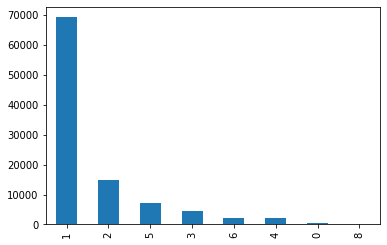

In [43]:
data["passenger_count"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='fare_amount', ylabel='Frequency'>

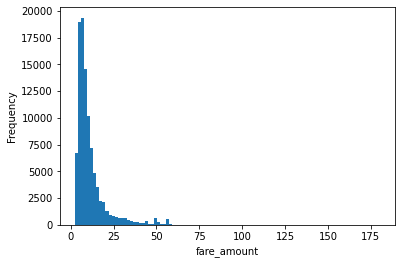

In [44]:
plt.xlabel("fare_amount")
data["fare_amount"].plot.hist(alpha=1, stacked=True, bins=100)

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

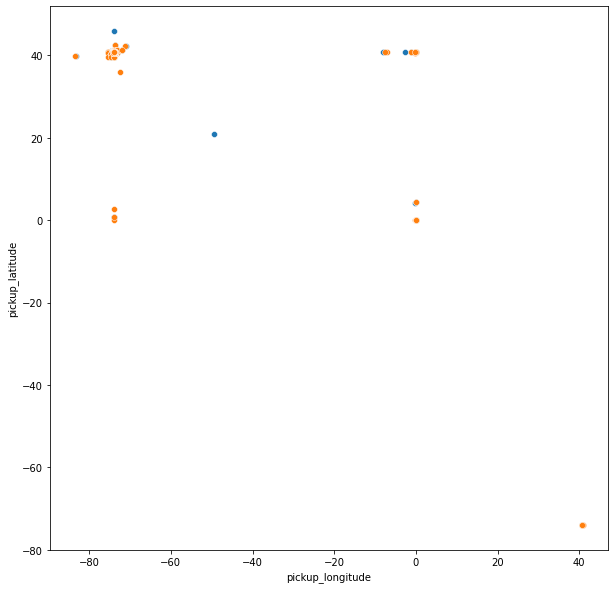

In [45]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data["pickup_longitude"], data["pickup_latitude"])
sns.scatterplot(data["dropoff_longitude"], data["dropoff_latitude"])

<h4>Ingeniería de Características</h4>

In [55]:
#Distancia entre dos puntos (Métrica de Haversine)
# two ways 
# 1  : Using the package

#from haversine import haversine
#origin = (39.50, 98.35)
#paris = (48.8567, 2.3508)
#haversine(origin, paris, miles=False) # return the distance in km

# 2 def a function

def radian(sexag):
    return sexag*(pi/180.0)

def Haversine(lat1,lon1,lat2,lon2):
    if (lat1 == lat2 and lon1 == lon2):
        return 0.0001 # por mientras
    diffLat = radian(lat2-lat1)
    diffLon = radian(lon2-lon1)
    h = sin(diffLat/2) ** 2 + cos(radian(lat1))*cos(radian(lat2))*(sin(diffLon/2)**2)
    dKm = 2.0 * 6371.345 * asin(sqrt(h))
    return dKm 

#print(Haversine(39.50, 98.35, 48.8567, 2.3508))

data['distance'] = data.apply(lambda row: Haversine(row['pickup_latitude'], row['pickup_longitude'],
                                                    row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
data.head(5)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
33909,6995983,12.9,-73.982005,40.755532,-73.986393,40.722167,1,2010,4,9,21,3.728595
92307,50914033,8.9,-73.992916,40.747968,-73.990090,40.771926,1,2010,4,27,13,2.674765
89107,1385641,15.0,-73.993250,40.738415,-73.948227,40.773012,1,2013,4,12,1,5.402235
9538,32496265,7.3,-73.987408,40.719842,-74.009960,40.728983,1,2011,12,12,20,2.155309
31008,28151968,15.7,-73.925891,40.761700,-73.999438,40.730170,3,2009,12,25,0,7.119348


<h4> Definición del modelo a entrenar </h4>

In [ ]:
#X = 
#y = data['fare_amount']
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 7)